TKO_3120 Machine Learning and Pattern Recognition

Image recognition exercise


## Introduction

The purpose of this task is to act as an introduction to image recognition. We will use some sample image data, three different groups, containing grass, sand and stairs images with around 62 each.
Images are with different resolution and dimensions and have been gathered from https://unsplash.com/

We will do some basic image manipulation to ensure consistent data, extract color and create Gray-Level-Co-Occurrence Matrixes to extract texture features from the data. We will plot the data with the Seaborn and Matplotlib libraries and build three different image classifiers. By testing out different hyperparameters, we will figure out which one of them is best suited for our current task. In the end, we will discuss the results of our model training.

## Data preparation

In this part, we will import our image data from the provided urls. We will also crop them according to the smallest image in the whole set. We want them all to be the same size, but cannot increase the size without any distortions, so the most intuitive option is to crop them all to the same size. We will also load the grayscaled versions of the images and reduce their color levels to eight different channels, so that we can peform some future operations on them.

In [ ]:
#I couldn't see the Markdown blocks in VSC, so please open this in Jupyter if you can

In [1]:
#imports go here
import pandas as pd
import numpy as np
import imageio.v2 as imageio
from matplotlib import pyplot as plt
from skimage import color
from skimage import io
from skimage.feature import graycomatrix, graycoprops
from skimage import data
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
#importing our images
grass_urls = np.loadtxt("grass.txt", dtype='U150')
sand_urls = np.loadtxt("sand.txt", dtype='U150')
stairs_urls = np.loadtxt("stairs.txt", dtype='U150')

In [3]:
#Cropping according to the smallest image
#Let's first find the smallest x- and y-values for every image type
x_values = []
y_values = []

#Looping through our  grass images
for x in grass_urls:
    #Reading our image data
    img = imageio.imread(x)
    #The x-value is stored in the first index
    x_values.append(img.shape[0])
    #The y-value is stored in the second index
    y_values.append(img.shape[1])

print(f"The smallest image among the grass images was the size of {min(x_values), min(y_values)}")

#For the sand images
x_values = []
y_values = []

#Looping through our sand images
for x in sand_urls:
    #Reading our image data
    img = imageio.imread(x)
    #The x-value is stored in the first index
    x_values.append(img.shape[0])
    #The y-value is stored in the second index
    y_values.append(img.shape[1])

print(f"The smallest image among the sand images was the size of {min(x_values), min(y_values)}")

#For the stairs images
x_values = []
y_values = []

#Looping through our  stairs images
for x in stairs_urls:
    #Reading our image data
    img = imageio.imread(x)
    #The x-value is stored in the first index
    x_values.append(img.shape[0])
    #The y-value is stored in the second index
    y_values.append(img.shape[1])

print(f"The smallest image among the stairs images was the size of {min(x_values), min(y_values)}")

The smallest image among the grass images was the size of (465, 1000)
The smallest image among the sand images was the size of (563, 1000)
The smallest image among the stairs images was the size of (563, 1000)


In [4]:
#We will go with the smallest image size (465, 1000) and crop all of the images for it to ensure consistent data
#(help from https://stackoverflow.com/questions/15589517/how-to-crop-an-image-in-opencv-using-python)

#Let's create some arrays to store our cropped images
grass_images = []
sand_images = []
stairs_images = []

#Looping through our grass images for resizing
for x in grass_urls:
    #Reading our image data
    img = imageio.imread(x)
    #Cropping our image to match the smallest image
    crop_img = img[0:465, 0:1000]
    #Adding our cropped image to dedicated array
    grass_images.append(crop_img)

for x in sand_urls:
    #Reading our image data
    img = imageio.imread(x)
    #Cropping our image to match the smallest image
    crop_img = img[0:465, 0:1000]
    #Adding our cropped image to dedicated array
    sand_images.append(crop_img)

for x in stairs_urls:
    #Reading our image data
    img = imageio.imread(x)
    #Cropping our image to match the smallest image
    crop_img = img[0:465, 0:1000]
    #Adding our cropped image to dedicated array
    stairs_images.append(crop_img)

In [5]:
#Let's then create separate arrays with the grayscaled images since we need to calculate rgb values in the upcoming part
#It seems that reading them as grayscale directly from the url is the best option
#Source: https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

#Let's also reduce the quantization level to 8 here
#Source: https://stackoverflow.com/questions/5906693/how-to-reduce-the-number-of-colors-in-an-image-with-opencv

#Grayscaled arrays
grass_gs = []
sand_gs = []
stairs_gs = []

#Looping through the images
for x in grass_urls:
    #Reading the image in grayscale
    img = io.imread(x, as_gray=True)
    #Cropping our image to match the smallest image
    crop_img = img[0:465, 0:1000]
    #Converting our float-based image to uint8 for better quantization
    crop_img = (crop_img * 255).astype(np.uint8)
    #256/32 equals 8, so this should result in a quantization level of 8
    level = 32
    #Floor division turns our pixels to the 0-7 range
    quant_img = crop_img // level
    #Adding our quantized and cropped image to the dedicated array
    grass_gs.append(quant_img)

#These are the same, so refer to the above for comments
for x in sand_urls:
    img = io.imread(x, as_gray=True)
    crop_img = img[0:465, 0:1000]
    crop_img = (crop_img * 255).astype(np.uint8)
    level = 32
    quant_img = crop_img // level
    sand_gs.append(quant_img)

for x in stairs_urls:
    img = io.imread(x, as_gray=True)
    crop_img = img[0:465, 0:1000]
    crop_img = (crop_img * 255).astype(np.uint8)
    level = 32
    quant_img = crop_img // level
    stairs_gs.append(quant_img)

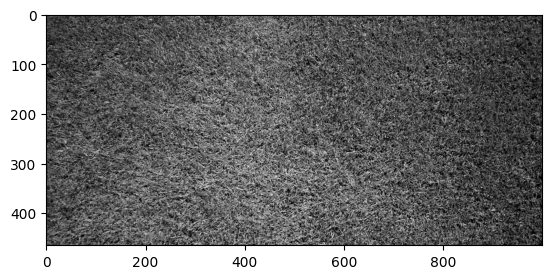

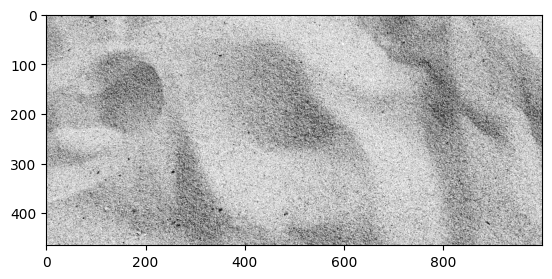

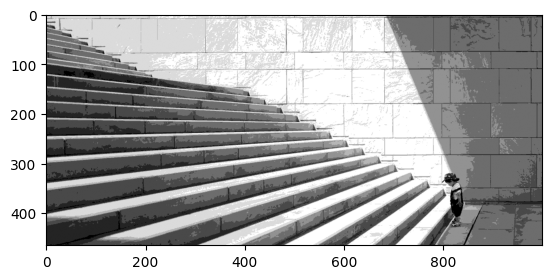

In [6]:
#Let's check that our images turned out to be in the correct size and color
plt.figure()
plt.imshow(grass_gs[0], cmap='gray')
plt.figure()
plt.imshow(sand_gs[0], cmap='gray')
plt.figure()
plt.imshow(stairs_gs[0], cmap='gray')

## Feature extraction

In this part we will extract some features from the data. Namely the mean and variance for each of the RGB values (6 features). We will also create Gray-Level-Co-Occurrence matrixes (GLCM) for the images and extract some correlation data from them. For the GLCM distances I chose 2 and 10, with the 2 capturing smaller, finer textures and the 10 capturing larger, coarser textures. I will then calculate one horizontal and one vertical correlation for each of these (4 features) bringing the total number of extracted features to 10.

In [7]:
#Let's calculate the mean and variance for each rgb color channel

#The input array
X = []
#The output array
y = []

#Looping through our images
for x in grass_images:
    #Empty array to store the features
    values = []
    #Empty array to store our labels
    labels = []
    #Red values for mean and variance calculation
    r_total = []
    #Blue values for mean and variance calculation
    g_total = []
    #Green values for mean and variance calculation
    b_total = []
    #Looping through our rows
    for row in x:
        #Looping through the columns in rows
        for col in row:
            #Adding the color values to their respective arrays
            r_total.append(col[0])
            g_total.append(col[1])
            b_total.append(col[2])
    #Calculating mean and variance with numpy and adding it to a feature array
    #We'll use a separate array to store image data for a specific image
    values.append(np.mean(r_total))
    values.append(np.mean(g_total))
    values.append(np.mean(b_total))
    values.append(np.var(r_total))
    values.append(np.var(g_total))
    values.append(np.var(b_total))
    #Corresponding label to the output array
    labels.append("grass")

    #Adding our feature array to the input array
    X.append(values)
    #Adding our label to the output array
    y.append(labels)

#Same as above so refer there for comments
for x in sand_images:
    values = []
    labels = []
    r_total = []
    g_total = []
    b_total = []
    for row in x:
        for col in row:
            r_total.append(col[0])
            g_total.append(col[1])
            b_total.append(col[2])
    values.append(np.mean(r_total))
    values.append(np.mean(g_total))
    values.append(np.mean(b_total))
    values.append(np.var(r_total))
    values.append(np.var(g_total))
    values.append(np.var(b_total))
    labels.append("sand")
    X.append(values)
    y.append(labels)

#Same as above so refer there for comments
for x in stairs_images:
    values = []
    labels = []
    r_total = []
    g_total = []
    b_total = []
    for row in x:
        for col in row:
            r_total.append(col[0])
            g_total.append(col[1])
            b_total.append(col[2])
    values.append(np.mean(r_total))
    values.append(np.mean(g_total))
    values.append(np.mean(b_total))
    values.append(np.var(r_total))
    values.append(np.var(g_total))
    values.append(np.var(b_total))
    labels.append("stairs")
    X.append(values)
    y.append(labels)


In [9]:
#Let's create our glcm matrixes

#A counter to move through the X array
counter = 0
for x in grass_gs:

    #Gray-Level-Co-Occurrence Matrixes
    glcm_hor = graycomatrix(x, distances=[2], angles=[0], levels=8)
    glcm_hor_long = graycomatrix(x, distances=[10], angles=[0], levels=8)
    glcm_ver = graycomatrix(x, distances=[2], angles=[(3*np.pi)/2], levels=8)
    glcm_ver_long = graycomatrix(x, distances=[10], angles=[(3*np.pi)/2], levels=8)

    #Correlations
    corr_hor = graycoprops(glcm_hor, 'correlation')[0][0]
    corr_hor_long = graycoprops(glcm_hor_long, 'correlation')[0][0]
    corr_ver = graycoprops(glcm_ver, 'correlation')[0][0]
    corr_ver_long = graycoprops(glcm_ver_long, 'correlation')[0][0]

    #Adding our correlations to the input array
    X[counter].append(corr_hor)
    X[counter].append(corr_hor_long)
    X[counter].append(corr_ver)
    X[counter].append(corr_ver_long)

    counter += 1

for x in sand_gs:

    #Gray-Level-Co-Occurrence Matrixes
    glcm_hor = graycomatrix(x, distances=[2], angles=[0], levels=8)
    glcm_hor_long = graycomatrix(x, distances=[10], angles=[0], levels=8)
    glcm_ver = graycomatrix(x, distances=[2], angles=[(3*np.pi)/2], levels=8)
    glcm_ver_long = graycomatrix(x, distances=[10], angles=[(3*np.pi)/2], levels=8)

    #Correlations
    corr_hor = graycoprops(glcm_hor, 'correlation')[0][0]
    corr_hor_long = graycoprops(glcm_hor_long, 'correlation')[0][0]
    corr_ver = graycoprops(glcm_ver, 'correlation')[0][0]
    corr_ver_long = graycoprops(glcm_ver_long, 'correlation')[0][0]

    #Adding our correlations to the input array
    X[counter].append(corr_hor)
    X[counter].append(corr_hor_long)
    X[counter].append(corr_ver)
    X[counter].append(corr_ver_long)

    counter += 1

for x in stairs_gs:

    #Gray-Level-Co-Occurrence Matrixes
    glcm_hor = graycomatrix(x, distances=[2], angles=[0], levels=8)
    glcm_hor_long = graycomatrix(x, distances=[10], angles=[0], levels=8)
    glcm_ver = graycomatrix(x, distances=[2], angles=[(3*np.pi)/2], levels=8)
    glcm_ver_long = graycomatrix(x, distances=[10], angles=[(3*np.pi)/2], levels=8)

    #Correlations
    corr_hor = graycoprops(glcm_hor, 'correlation')[0][0]
    corr_hor_long = graycoprops(glcm_hor_long, 'correlation')[0][0]
    corr_ver = graycoprops(glcm_ver, 'correlation')[0][0]
    corr_ver_long = graycoprops(glcm_ver_long, 'correlation')[0][0]

    #Adding our correlations to the input array
    X[counter].append(corr_hor)
    X[counter].append(corr_hor_long)
    X[counter].append(corr_ver)
    X[counter].append(corr_ver_long)

    counter += 1


In [11]:
#standardizing our data
X = StandardScaler().fit_transform(X)

## Feature relationships

Let's create a pairplot to view any possible linear relationships.

In [12]:
#Converting our array to a dataframe so it works with our plotting packages
X = pd.DataFrame(data=X, columns=['r_mean', 'g_mean', 'b_mean', 'r_variance', 'g_variance', 'b_variance', 'hor_corr', 'hor_corr_long', 'vert_corr', 'vert_corr_long'])

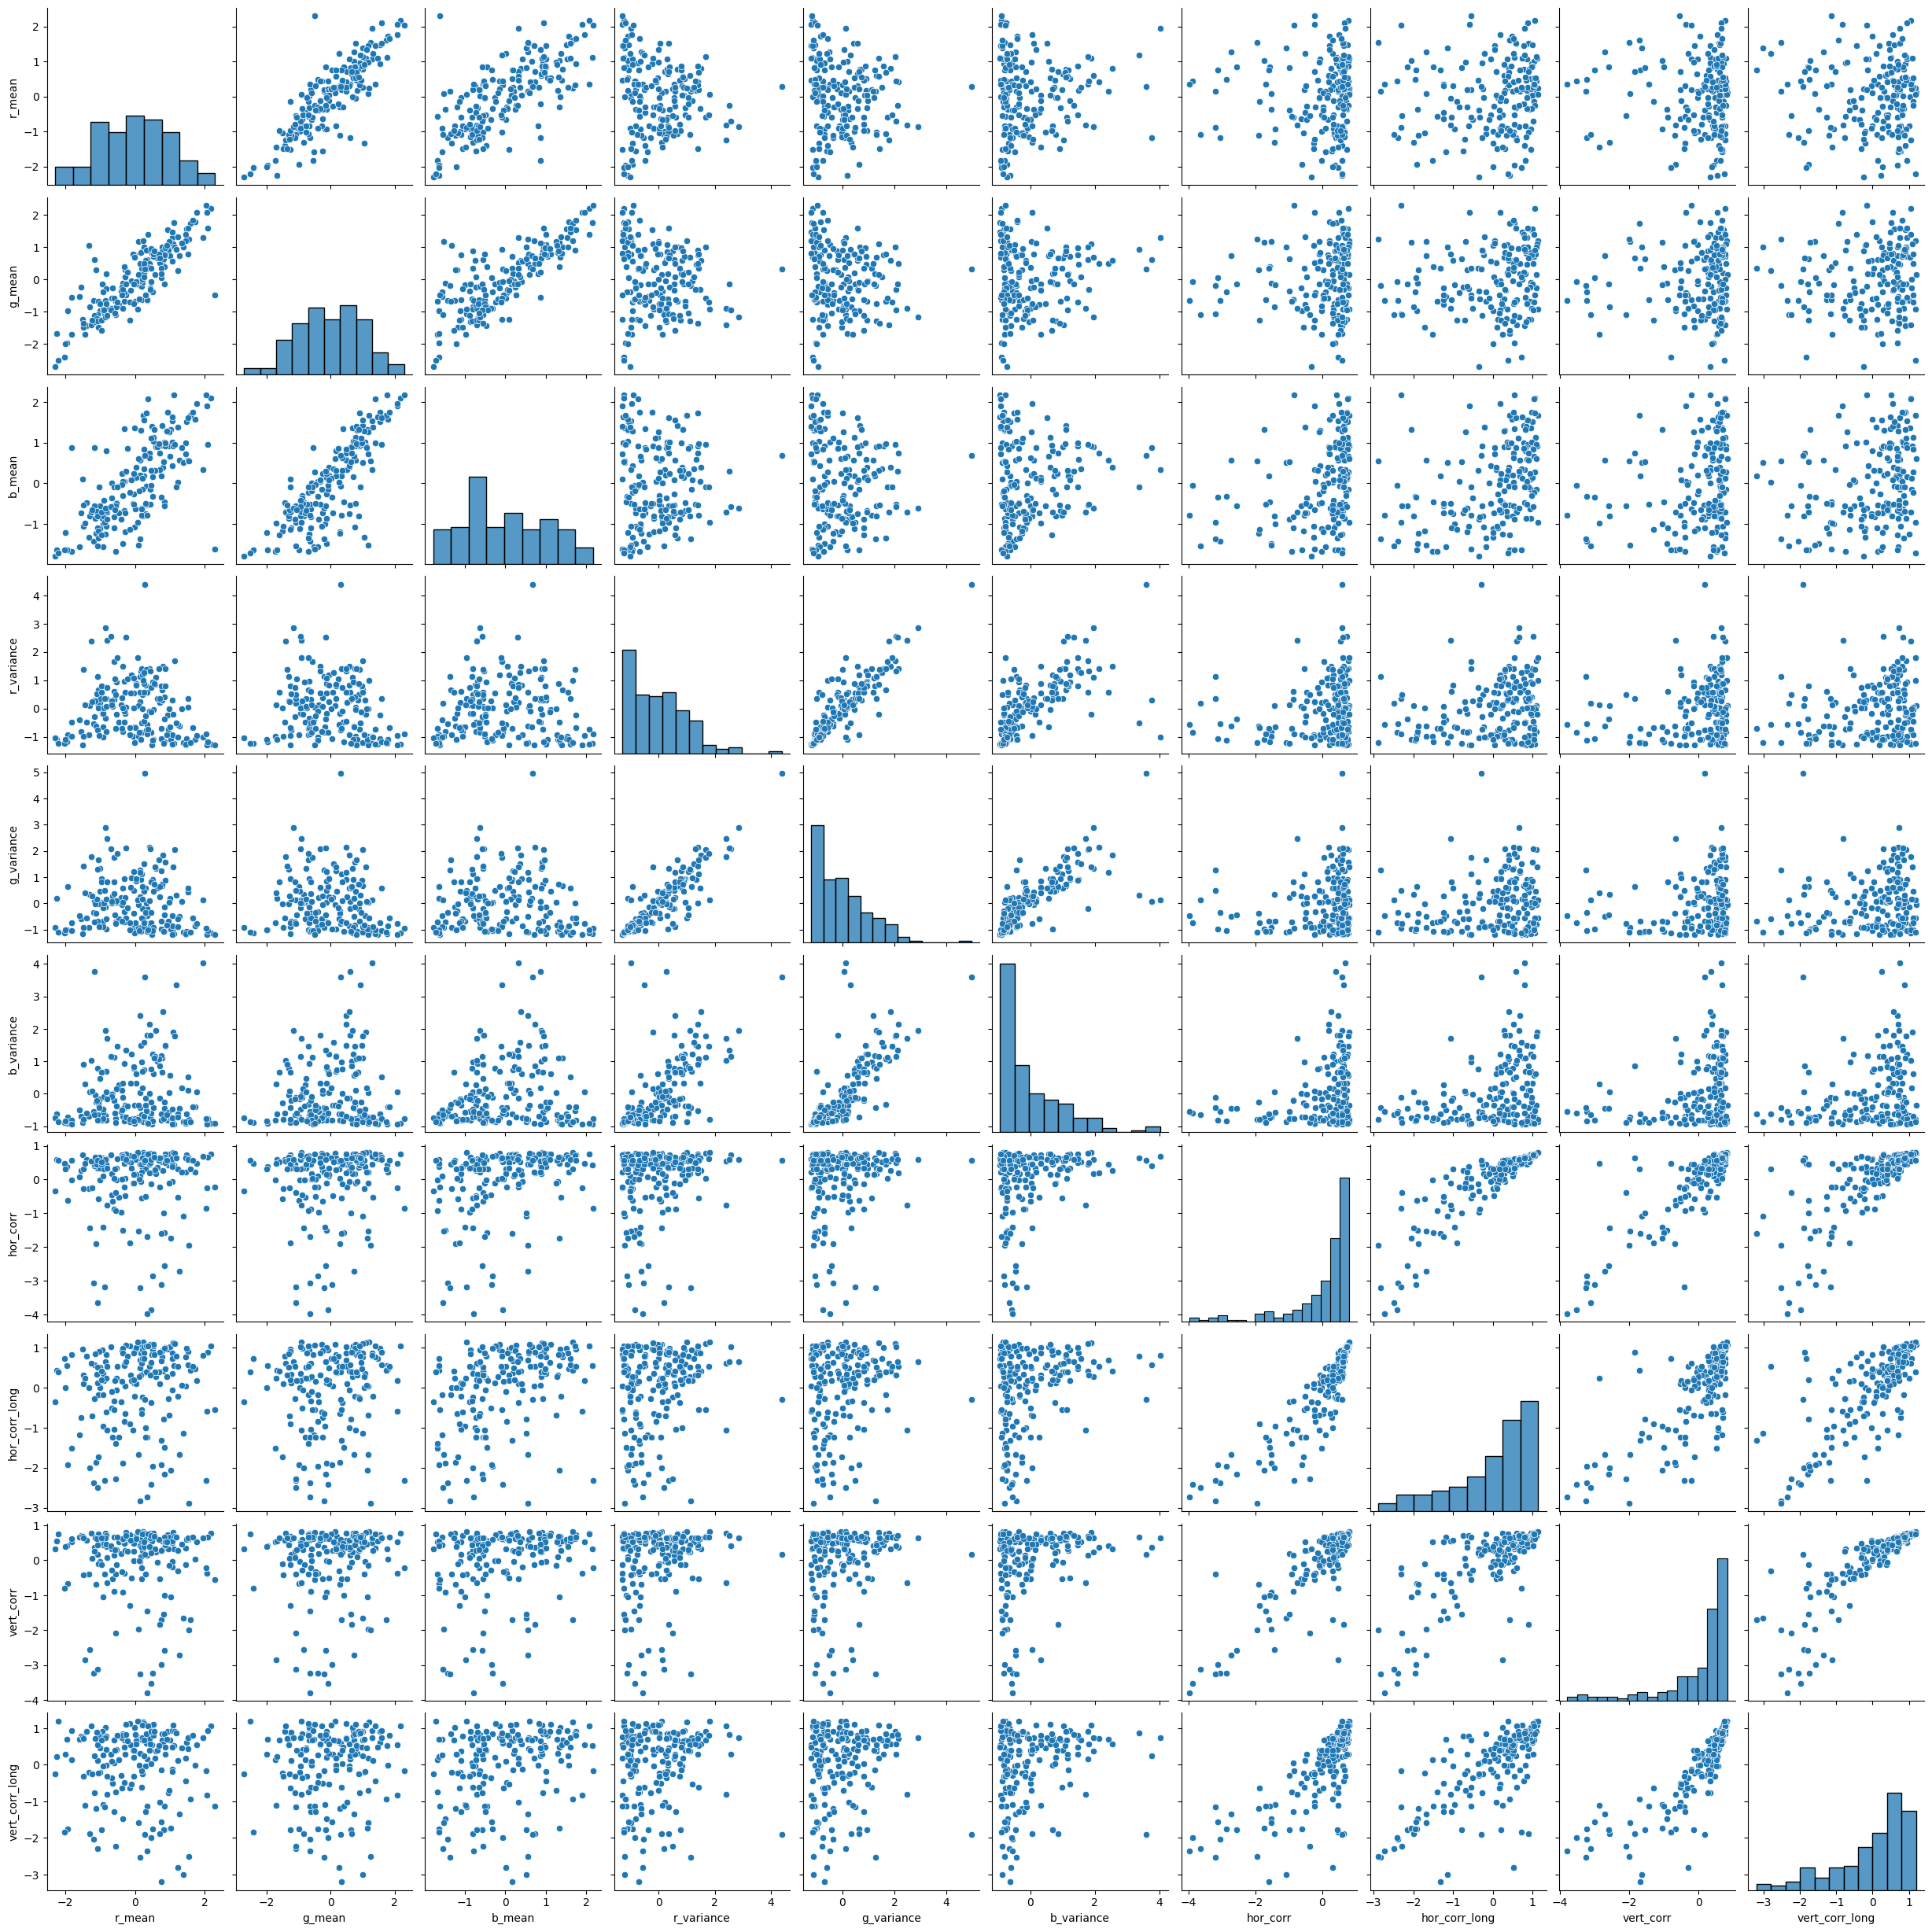

In [13]:
#Pairplot from Seaborn
sns.pairplot(X)

<p>The strongest linear dependence happens with the mean values of red and green, green and blue. There's some linear dependence in the red/green variance pair and green/blue variance pair. Albeit not quite linear, there could be some kind of linear dependence between the longer vertical and horizontal correlations. </p>

### Histograms

Let's plot a histogram for every feature to see if any image classes have any discriminate power over the other classes.

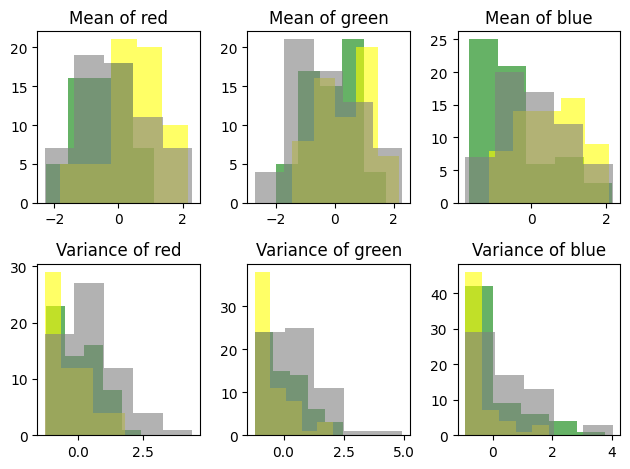

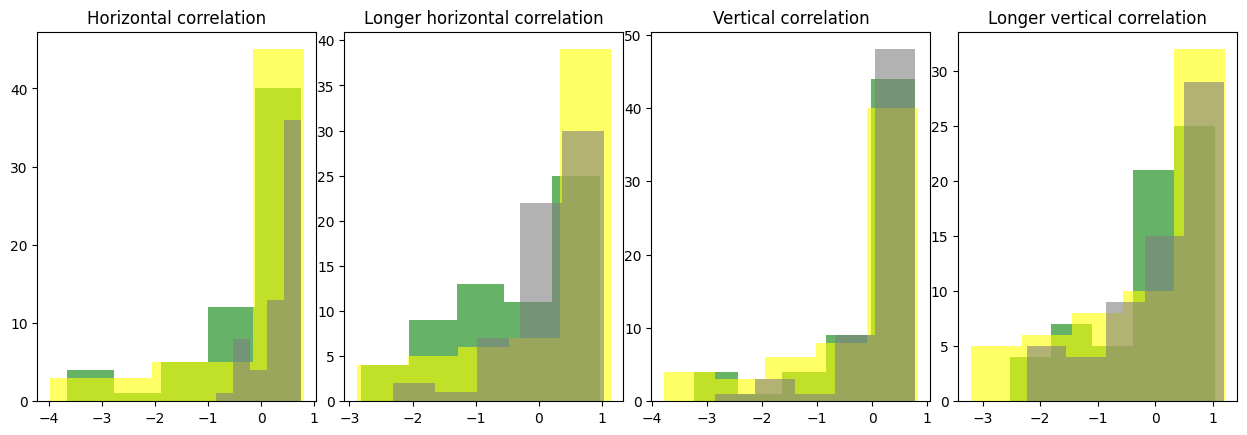

In [14]:
#Subplots to fit our color features
fig, axs = plt.subplots(2,3)

#Let's temporaily add the labels to our data
temp = []
for x in y:
    temp.append(x[0])

X['label'] = temp
#Checking for unique labels
labels = X["label"].unique()
#Green for grass pictures, yellow for sand pictures, gray for stairs pictures
colors = ["green", "yellow", "gray"]

#We loop over our labels and their matching colors
for label, color in zip(labels, colors):
    #Taking a subset of images with the correct label
    subset = X[X["label"] == label]
    #Building histograms based on features, zscore standardizing them in the process
    axs[0,0].hist(subset["r_mean"], bins=5, alpha=0.6, label=label, color=color)
    axs[0,1].hist(subset["g_mean"], bins=5, alpha=0.6, label=label, color=color)
    axs[0,2].hist(subset["b_mean"], bins=5, alpha=0.6, label=label, color=color)
    axs[1,0].hist(subset["r_variance"], bins=5, alpha=0.6, label=label, color=color)
    axs[1,1].hist(subset["g_variance"], bins=5, alpha=0.6, label=label, color=color)
    axs[1,2].hist(subset["b_variance"], bins=5, alpha=0.6, label=label, color=color)
    #Setting correct titles for our histograms for easier understanding
    axs[0,0].set_title('Mean of red')
    axs[0,1].set_title('Mean of green')
    axs[0,2].set_title('Mean of blue')
    axs[1,0].set_title('Variance of red')
    axs[1,1].set_title('Variance of green')
    axs[1,2].set_title('Variance of blue')

#Making sure the titles do not overlap
plt.tight_layout()
plt.show()

#Creating another subplot for the correlations
fig2, axs2 = plt.subplots(1,4)

#Same as above
for label, color in zip(labels, colors):
    subset = X[X["label"] == label]
    axs2[0].hist(subset["hor_corr"], bins=5, alpha=0.6, label=label, color=color)
    axs2[1].hist(subset["hor_corr_long"], bins=5, alpha=0.6, label=label, color=color)
    axs2[2].hist(subset["vert_corr"], bins=5, alpha=0.6, label=label, color=color)
    axs2[3].hist(subset["vert_corr_long"], bins=5, alpha=0.6, label=label, color=color)
    axs2[0].set_title('Horizontal correlation')
    axs2[1].set_title('Longer horizontal correlation')
    axs2[2].set_title('Vertical correlation')
    axs2[3].set_title('Longer vertical correlation')

#Longer titles need a bit wider adjustments
fig2.subplots_adjust(right=2, wspace=0.1)

plt.show()


<p> There seems not to be a lot of discriminative power at play here. It seems that the sand images tend to come out on top in almost all of the features except for mean for blue and green and vertical correlation. It clearly has some discriminate power in the longer horizontal correlation and the variance of green. The longer horizontal correlation can be explained by the images containing "horizontal lines" of sand, making the larger pixel distances horizontally more correlated with each other. There are also larger color changes with the parts obscured by shadows and the parts in sunlight, so it might help to explain the discriminative power in the variance of green. The sand images also seem to be most "homogenous" of the three, sharing a constant texture throughout the image, as shown in the grayscaled example above. </p>

### PCA

Here we'll create a Primary Component Analysis based on our data. We'll create three clusters, with each color representing their image data.

In [16]:
#The labels are in the way of the PCA transformation so we'll temporarily remove them
X = X.drop(columns=['label'])

In [17]:
#Performing the PCA (source: https://builtin.com/machine-learning/pca-in-python)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
pcaX = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

In [18]:
#And we will add the labels back now that the PCA transformation is done
pcaX['label'] = temp

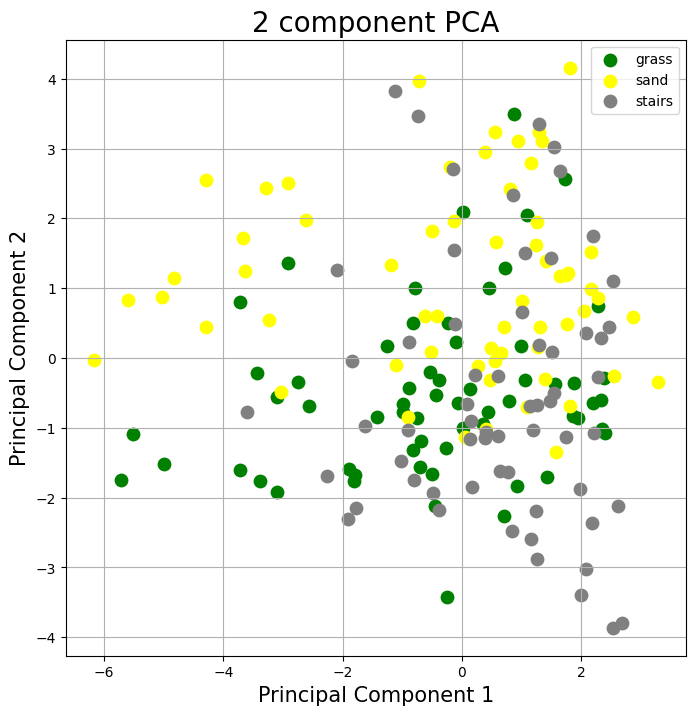

In [29]:
#Creating a figure and labels for the PCA plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

#Naming our labels and colors
targets = ['grass', 'sand', 'stairs']
colors = ['green', 'yellow', 'gray']
#Creating a scatter plot based on the labels
for target, color in zip(targets,colors):
    indicesToKeep = pcaX['label'] == target
    ax.scatter(pcaX.loc[indicesToKeep, 'principal component 1'] ,pcaX.loc[indicesToKeep, 'principal component 2'], color = color, s = 80)
ax.legend(targets)
ax.grid()

<p> If there were no colors present, I would not be able to distinguish the clusters. I can sort of imagine where the cluster centroids would line up. The grass and stairs images seem to overlap a bit, but the sand ones are all almost above the principal components 2's axis 0. It might give us some clues that the sand image differ from the grass and stairs ones slightly. </p>

## Build classifiers and select the best hyperparameters with cross validation

In this part we will utilize the 5-fold stratified cross validation and try out three different classifiers. We will find out the best hyperparameters for each one from a specified set and report the accuracy acquired by them. In addition, we will explore the feature importance through the Random Forest model.

In [21]:
#Array to hold our scores
scores = []

#Taking our labels back
y = temp
#Converting our labels to a series object
y = pd.Series(y)
#Initializing our cross validation
skf = StratifiedKFold(n_splits=5)
#Selecting the model
model = RidgeClassifier()
#Hyperparameters
parameters = {'alpha':[0.001, 0.01, 0.1, 1.0]}
for i, (train_index, test_index) in enumerate(skf.split(X,y)):

    #Using GridSearchCV to discover the best hyperparameters
    Ridge_reg = GridSearchCV(model, parameters, scoring='accuracy')
    #Train and test splits
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index].squeeze(), y.iloc[test_index].squeeze()

    #Training our model with the data
    Ridge_reg.fit(X_train, y_train)
    #Saving our best parameters and score
    scores.append([Ridge_reg.best_params_, Ridge_reg.best_score_])

print(scores)

[[{'alpha': 1.0}, 0.7011494252873562], [{'alpha': 0.001}, 0.654712643678161], [{'alpha': 0.001}, 0.6873563218390804], [{'alpha': 0.001}, 0.6742528735632184], [{'alpha': 0.001}, 0.7291954022988505]]


The best accuracy was obtained with the hyperparameter alpha: 0.001 and it was 0.729

In [22]:
#Refer to above for comments
scores = []

model = MLPClassifier()
parameters = {'hidden_layer_sizes':[15,20,25,30,35,40],
              'activation':['tanh','relu'],
              'solver':['sgd','adam'],
              'validation_fraction':[0.1,0.3],
              'alpha':[0.01,0.1,1],
             'max_iter':[10000]}
for i, (train_index, test_index) in enumerate(skf.split(X,y)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index].squeeze(), y.iloc[test_index].squeeze()

    MLP_reg = GridSearchCV(model, parameters, scoring='accuracy')
    MLP_reg.fit(X_train, y_train)
    scores.append([MLP_reg.best_params_, MLP_reg.best_score_])

params, accuracy = max(scores, key=lambda x: x[1])
print([params,accuracy])
#This cell runs for an hour due to the 144 different parameter combinations

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 30, 'max_iter': 10000, 'solver': 'adam', 'validation_fraction': 0.3} 0.789655172413793


The best result was obtained with the hyperparameters:
- activation: relu
- alpha: 0.01
- hidden_layer_size: 30
- max_iter: 10000 (this can be smaller but I played it safe)
- solver: adam
- validation fraction: 0.3

And it resulted in an accuracy of 0.789

In [23]:
#Refer to above for comments
scores = []

model = RandomForestClassifier()
parameters = {'n_estimators':[100,150,200,250,300],
              'max_features':['sqrt','log2',None],
              'bootstrap':[True,False]}

for i, (train_index, test_index) in enumerate(skf.split(X,y)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index].squeeze(), y.iloc[test_index].squeeze()

    RFC = GridSearchCV(model, parameters, scoring='accuracy')
    RFC.fit(X_train, y_train)
    scores.append([RFC.best_params_, RFC.best_score_])

print(scores)

[[{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 150}, 0.6547126436781608], [{'bootstrap': True, 'max_features': None, 'n_estimators': 100}, 0.6542528735632184], [{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}, 0.7151724137931035], [{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 150}, 0.6744827586206897], [{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 100}, 0.7296551724137931]]


The best result was obtained with the hyperparameters:
- bootstrap: True
- max_features: sqrt
- n_estimators: 100

And it resulted in an accuracy of 0.715

Now that we know the best hyperparameters, we can use them to find out the feature importance for each feature by constructing a separate RandomForestClassifier based on them.

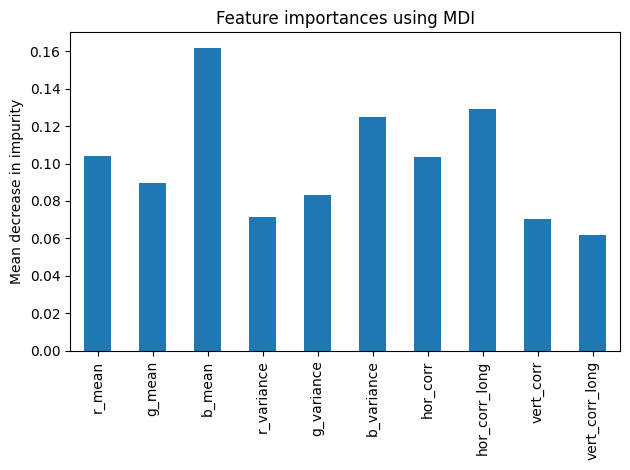

In [36]:
#Source: Documentation from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#New classifier
RFC = RandomForestClassifier(bootstrap=True, max_features='sqrt', n_estimators=100)
#Fitting our data
RFC.fit(X, y)
#Calculating importances
importances = RFC.feature_importances_
#Creating a Series object with the corresponding labels
forest_importances = pd.Series(importances, index=['r_mean', 'g_mean', 'b_mean', 'r_variance', 'g_variance', 'b_variance', 'hor_corr', 'hor_corr_long', 'vert_corr', 'vert_corr_long'])

#Plotting our importances
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The feature importance matrix seems to highlight mean of blue the most, with variance of blue and longer horizontal correlation coming at close second. The histograms seemed to highlight blue as differentiating between the grass images and others. It seems it was more important that what I gathered from the histograms.
If I had to give it my guess, due to the sand images having several different "stronger" features as seen in the histrograms helping them differentiate from the other image types, the effect of them wasn't so directed towards a specific feature. When the grass images only had the mean of blue as a strong differenciating factor, it gave it such a strong importance in this part.

## Estimate the performance of the models with nested cross-validation

The best parameters were {'alpha': 1.0} with an accuracy of 0.8648648648648649
Mean accuracy of the outer rounds: 0.6907882882882882


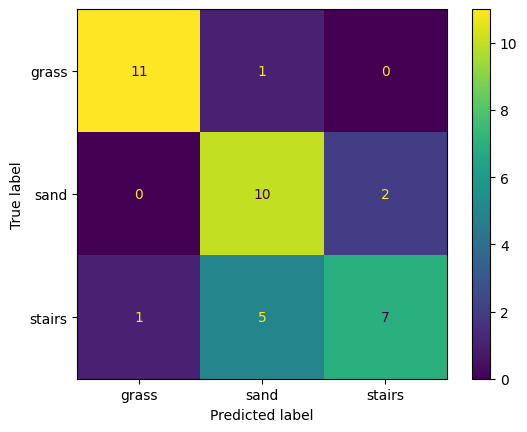

In [24]:
#Same parameters from the earlier experiment
model = RidgeClassifier()
ridge_parameters = {'alpha':[0.001, 0.01, 0.1, 1.0]}

#Arrays to hold accuracies, best hyperparameters and mean accuracies
accuracies = []
parameters = []
mean_accuracy = []

#Initializing outer cross validation
outer_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


for train, test in outer_kfold.split(X,y):

    #Outer train and test sets
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train].squeeze(), y.iloc[test].squeeze()

    #Initializing inner cross validation
    inner_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    for inner_train, inner_test in inner_kfold.split(X_train,y_train):

        #Inner train and test sets
        X_inner_train, X_inner_test = X_train.iloc[inner_train], X_train.iloc[inner_test]
        y_inner_train, y_inner_test = y_train.iloc[inner_train].squeeze(), y_train.iloc[inner_test].squeeze()

        #Using gridsearchcv to discover the best hyperparameters
        Ridge_reg = GridSearchCV(model, ridge_parameters, scoring='accuracy', cv=inner_kfold)
        #Fitting our data
        Ridge_reg.fit(X_inner_train, y_inner_train)

        #Calculating the accuracy and adding it to the array
        accuracies.append(Ridge_reg.score(X_inner_test, y_inner_test))
        #Adding the best parameters resulting in the accuracy to the parameters
        parameters.append(Ridge_reg.best_params_)

    #Adding the mean to the mean accuracies
    mean_accuracy.append(np.mean(accuracies))

#Finding the largest accuracy
index_max = np.argmax(accuracies)
print(f"The best parameters were {parameters[index_max]} with an accuracy of {accuracies[index_max]}")
print(f"Mean accuracy of the outer rounds: {np.mean(mean_accuracy)}")

#Printing the confusion matrix
cm = confusion_matrix(y_inner_test, Ridge_reg.predict(X_inner_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Ridge_reg.classes_)
disp.plot()
plt.show()

The best parameters were {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 20, 'max_iter': 5000, 'solver': 'adam', 'validation_fraction': 0.1} with an accuracy of 0.8648648648648649
Mean accuracy of the outer rounds: 0.7048873873873874


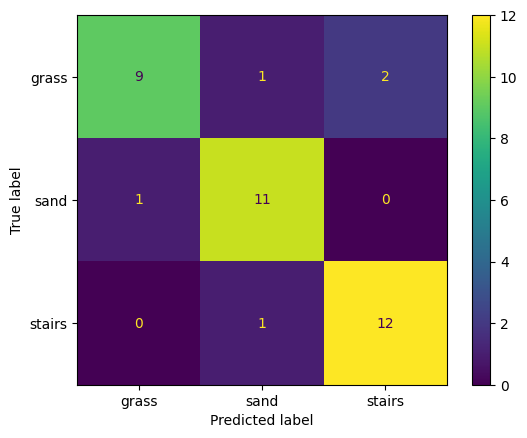

In [25]:
#Refer to above for comments
#Same parameters from the earlier experiment
model = MLPClassifier()
MLP_parameters = {'hidden_layer_sizes':[15,20,25,30,35,40],
              'activation':['tanh','relu'],
              'solver':['sgd','adam'],
              'validation_fraction':[0.1,0.3],
              'alpha':[0.01,0.1,1],
             'max_iter':[5000]}

accuracies = []
parameters = []
mean_accuracy = []


outer_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train, test in outer_kfold.split(X,y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train].squeeze(), y.iloc[test].squeeze()

    inner_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    for inner_train, inner_test in inner_kfold.split(X_train,y_train):
        X_inner_train, X_inner_test = X_train.iloc[inner_train], X_train.iloc[inner_test]
        y_inner_train, y_inner_test = y_train.iloc[inner_train].squeeze(), y_train.iloc[inner_test].squeeze()

        MLP = GridSearchCV(model, MLP_parameters, scoring='accuracy', cv=inner_kfold)
        MLP.fit(X_inner_train, y_inner_train)

        accuracies.append(MLP.score(X_inner_test, y_inner_test))
        parameters.append(MLP.best_params_)

    mean_accuracy.append(np.mean(accuracies))

index_max = np.argmax(accuracies)
print(f"The best parameters were {parameters[index_max]} with an accuracy of {accuracies[index_max]}")
print(f"Mean accuracy of the outer rounds: {np.mean(mean_accuracy)}")

cm = confusion_matrix(y_inner_test, MLP.predict(X_inner_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=MLP.classes_)
disp.plot()
plt.show()

The best parameters were {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200} with an accuracy of 0.7837837837837838
Mean accuracy of the outer rounds: 0.680990990990991


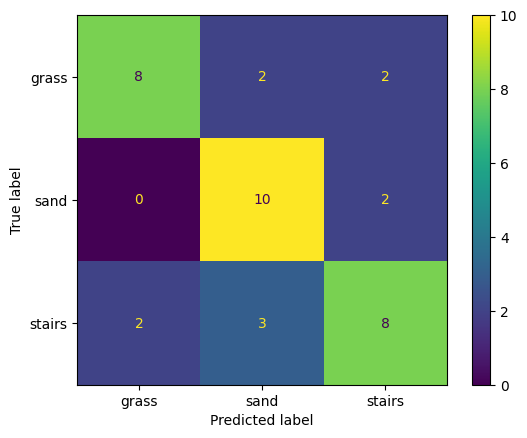

In [26]:
#Refer to above for comments
#Same parameters from the earlier experiment
model = RandomForestClassifier()
RF_parameters = {'n_estimators':[100,150,200,250,300],
              'max_features':['sqrt','log2',None],
              'bootstrap':[True,False]}

accuracies = []
parameters = []
mean_accuracy = []


outer_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train, test in outer_kfold.split(X,y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train].squeeze(), y.iloc[test].squeeze()

    inner_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    for inner_train, inner_test in inner_kfold.split(X_train,y_train):
        X_inner_train, X_inner_test = X_train.iloc[inner_train], X_train.iloc[inner_test]
        y_inner_train, y_inner_test = y_train.iloc[inner_train].squeeze(), y_train.iloc[inner_test].squeeze()

        RF = GridSearchCV(model, RF_parameters, scoring='accuracy', cv=inner_kfold)
        RF.fit(X_inner_train, y_inner_train)

        accuracies.append(RF.score(X_inner_test, y_inner_test))
        parameters.append(RF.best_params_)

    mean_accuracy.append(np.mean(accuracies))

index_max = np.argmax(accuracies)
print(f"The best parameters were {parameters[index_max]} with an accuracy of {accuracies[index_max]}")
print(f"Mean accuracy of the outer rounds: {np.mean(mean_accuracy)}")

cm = confusion_matrix(y_inner_test, RF.predict(X_inner_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=RF.classes_)
disp.plot()
plt.show()

By looking at only the mean accuracies, it seems that the MLP performed the best. The mean accuracy for each of them was around 68-70%. This means that they performed well, but there could be a lot of room to improve. Calculating the mean accuracy is also important since it gives us info on how the model "generally" performs. If we would give it let's say, 40 new different images to classify, the mean gives us better insights on how it would perform, compared to looking at just the best accuracy.

## Discussion

Out of the models, Multilayer Percepton performed the best. I think it was due it's power to learn nonlinear relationships, making it strong in classification tasks. I also think our data had some pretty clear, simple differences in the given textures that made this task not so complex.

The main limitations are pretty common: each of the datasets contained only around 62 images, so if we had larger datasets, we could get more data for the models. The model hyperparameters could be explored more, but trying out lots of them can result in very high runtimes. Even now, the MLP ran for almost an hour in Colab with the most powerful processors. I didn't check all of the images, but there can be a risk of overfitting if the images are too similar among each other.

Some other Gray-Level-Co-Correlation matrixes could also be tried out, since there are eight commonly available directions and lots of other pixel distances to be tried out. Other cross-validation techniques could also be used, like Leave-One-Out-Group Validation. I'm not sure if it would improve the results since we only have three different groups, but it could be worthwhile to try out. Mirroring and rotating some of the images randomly could also ensure that the model will not overfit.